# Stream Learning applied to 3W dataset

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook fits the 3W dataset to models of the River package.

# 2. Imports and Configurations

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import pickle
import graphviz
import river
from copy import deepcopy

from river import stream, feature_extraction as fx, compose, stats, preprocessing, tree, metrics, evaluate
from river import linear_model, optim, drift, anomaly, utils, ensemble, multiclass, datasets, time_series
from river import imblearn

import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
river.__version__

'0.14.0'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [3]:
class d3w():
    '''
    Class for managing Petrobras 3W dataset
    '''
    def __init__(self, path3w):
        self.path3w = path3w
        self.df = self.__load_df()
        return

    def __load_df(self):

        d = dict()
        d['origin'] = []
        d['well'] = []
        d['ts'] = []
        d['label'] = []
        d['path'] = []
        d['nlines'] = []
        for i in pathlib.Path(self.path3w).iterdir():
            if i.stem.isnumeric():
                print(i)
                label = int(i.stem)
                for fp in i.iterdir():
                    # Considers only csv files
                    if fp.suffix == ".csv":
                        d['well'].append(None)
                        d['ts'].append(None)
                        if (fp.stem.startswith("SIMULATED")):
                            d['origin'].append('S')
                        elif fp.stem.startswith("DRAWN"):
                            d['origin'].append('D')
                        else:
                            d['origin'].append('R')
                            if fp.stem.startswith('WELL'):
                                s = fp.stem
                                d['well'][-1] = int(s[5:10])
                                d['ts'][-1] = pd.Timestamp(year=int(s[11:15]), month=int(s[15:17]), day=int(s[17:19]), 
                                                           hour=int(s[19:21]), minute=int(s[21:23]), second=int(s[23:25]))
                        d['label'].append(label)
                        d['path'].append(fp)
                        d['nlines'].append(self.file_len(fp)-1)
                        
        return pd.DataFrame(d)
    
    def split(self, real=True, simul=True, drawn=True, well=None, label=None, test_size=0.2, val_size=0.1, sample_n=None):
        
        tmp0_df = self.get_df(real, simul, drawn, well, label)
        
        if sample_n is not None:
            N = len(tmp0_df.index)
            if N > sample_n:
                ds_list = []
                for i, ni in tmp0_df.groupby('label').count().nlines.items():
                    ns = ni*sample_n//N
                    ds_list.append(tmp0_df[tmp0_df.label == i].sample(n=ns, random_state=200560))
                tmp0_df = pd.concat(ds_list)            
        
        tmp_df, test_df = sklearn.model_selection.train_test_split(tmp0_df, 
                                                        test_size=test_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp0_df['label'])
        
        if val_size == 0:
            print('Instances Train: {}  Test: {}'.format(len(tmp_df.index), 
                                                         len(test_df.index)))
            return tmp_df.reset_index(drop=True),\
                   test_df.reset_index(drop=True)
        
        train_df, val_df = sklearn.model_selection.train_test_split(tmp_df, test_size=val_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp_df['label'])
        print('Instances Train: {}  Test: {}  Validation: {}'.format(len(train_df.index), 
                                                                     len(test_df.index), 
                                                                     len(val_df.index)))
        
        return train_df.reset_index(drop=True),\
               test_df.reset_index(drop=True),\
               val_df.reset_index(drop=True)
    
    def file_len(self, filename):
        j = 0
        with open(filename) as f:
            for i, x in enumerate(f):
                if x.strip() == '':
                    j += 1
        return i + 1 - j
    
    def get_df(self, real=True, simul=True, drawn=True, well=None, label=None):

        if label is not None:
            if not isinstance(label, list):
                label = [label]
            return self.df[self.df.label.isin(label)].drop(columns=['origin', 'well']).reset_index(drop=True)
            
        if well is not None:
            return self.df[self.df['well']==well].drop(columns=['origin', 'well']).reset_index(drop=True)
        
        sel = []
        if real:
            sel.append('R')
        if simul:
            sel.append('S')
        if drawn:
            sel.append('D')
        if sel:
            return self.df[self.df['origin'].isin(sel)].drop(columns=['origin', 'well']).reset_index(drop=True)
    
    @property
    def all(self):
        return self.df.drop(columns=['origin'])
    @property
    def real(self):
        return self.df[self.df['origin']=='R'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def simul(self):
        return self.df[self.df['origin']=='S'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def drawn(self):
        return self.df[self.df['origin']=='D'].drop(columns=['origin']).reset_index(drop=True)


In [4]:
if pathlib.Path('dset_tfm1.pkl').exists():
  with open('dset_tfm1.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset_tfm1.pkl', 'wb') as f:
      pickle.dump(dset, f)

Subset for labels 0 (Normal conditions) and 4 (FLOW INSTABILITY).

In [5]:
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[[0,1,2,3,4,5,6,7,8,101,102,103,104,105,106,107,108]]

train_df, test_df, val_df = dset.split(label=[0, 4], test_size=0.5, val_size=0.1, sample_n=None)

Instances Train: 423  Test: 471  Validation: 47


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.  

            TYPE OF UNDESIRABLE EVENT       WINDOW SIZE   
		
            1 - ABRUPT INCREASE OF BSW       12h 
            2 – SPURIOUS CLOSURE OF DHSV     5min–20min 
            3 – SEVERE SLUGGING         	 5h 
            4 – FLOW INSTABILITY             15min 
            5 – RAPID PRODUCTIVITY LOSS 	 12h 
            6 – QUICK RESTRICTION IN PCK     15min 
            7 – SCALING IN PCK               72h 
            8 – HYDRATE IN PRODUCTION LINE   30min–5h 


In [6]:
class CustomGen():
    '''instance generator for the 3W files in dset'''
    
    def __init__(self, dset, flist, target, scaleb=False, out_time=False, ifileb=False, min_std=None):
        self.dset = dset
        self.flist = flist
        self.target = target
        self.scaleb = scaleb
        self.out_time = out_time
        self.ifileb = ifileb
        self.nfiles = len(dset.index)
        self.min_std = min_std
        return
    
    def todataframe(self):
        ds_list = []
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            ds['ifile'] = ifile
            
            ds_list.append(ds)
        return pd.concat(ds_list, ignore_index=True)
    
    def iter(self, max_n=None):
        n = 0
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            if self.scaleb:
                np.seterr(divide='ignore', invalid='ignore')
                dfd = self.scale(ds[self.flist]).to_dict(orient='records')
                np.seterr(divide='warn', invalid='warn')
            else:
                dfd = ds[self.flist].to_dict(orient='records')
            for i, x in enumerate(dfd):
                #assert isinstance(df.iloc[i][self.target], np.int32), 'class not an integer!'
                result = []
                if self.ifileb:
                    result.append(ifile)
                if self.out_time:
                    result.append(ds.index[i])
                yield result + [x, ds.iloc[i][self.target]]
                n += 1
                if max_n is not None and n > max_n:
                    break
            if max_n is not None and n > max_n:
                break

        return
    
    def scale(self, df):
        xm = df[self.flist].mean()
        sm = df[self.flist].std()
        if self.min_std is not None:
            sm = pd.concat([sm, pd.Series(self.min_std)]).groupby(level=0).max()[sm.index]
        return (df[self.flist]-xm)/sm

    def plot(self, ifiles):
        
        if isinstance(ifiles, list):
            n_files = len(ifiles)
        else:
            ifiles = [ifiles]
            n_files = 1
        
        fig, axs = plt.subplots(nrows=len(self.flist)+1, ncols=n_files, figsize=(10, 12), sharex='col')
        axs = axs.flatten()

        dss = []
        supt = ''
        for i_col, i_f in enumerate(ifiles):
        
            dss.append(pd.read_csv(self.dset['path'][i_f], parse_dates=["timestamp"]))
            #ds = ds.drop_duplicates(subset='timestamp', keep="last").sort_values(by=['timestamp']).reset_index(drop=True)
            if np.any(dss[i_col][self.target].isna()):
                ds[i_col][self.target] = ds[i_col][self.target].fillna(method='ffill')
            
            supt += str(self.dset['path'][i_f])
            if i_col != n_files-1:
                supt += '\n'
            fig.suptitle(supt)

            for i, vs in enumerate(self.flist):
                axs[i*n_files+i_col].plot(dss[i_col].timestamp[::60], dss[i_col][vs][::60])
                if i_col == 0:
                    axs[i*n_files+i_col].set_ylabel(vs)
        
            id = np.argsort(dss[i_col][self.target])
            t = [dss[i_col].timestamp[i] for i in id][::60]
            y = [str(dss[i_col][self.target][i]) for i in id][::60]
        
            axs[(i+1)*n_files+i_col].scatter(t, y, marker='.')
        
            axs[(i+1)*n_files+i_col].xaxis.set_tick_params(rotation=45)
            
            if i_col == 0:
                axs[(i+1)*n_files+i_col].set_ylabel(self.target)
        
            axs[(i+1)*n_files+i_col].set_xlabel('Date')
            
        
        for ax in axs.flatten():
            ax.grid(visible=True)

        return fig  


In [7]:
gen = CustomGen(train_df, flist, 'class', scaleb=True, out_time=True, ifileb=True)
n = 0
for i, time, x, t in gen.iter():
    if i == 3:
        print(i, time, x, t)
        n += 1
        if n > 3:
            break

3 2017-06-11 08:04:00 {'P-PDG': -2.069257862480551, 'P-TPT': 0.41264236539281224, 'T-TPT': 1.9997962148887143, 'P-MON-CKP': nan, 'T-JUS-CKP': nan, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2017-06-11 08:05:00 {'P-PDG': -1.9027688361345931, 'P-TPT': 0.10911063519790425, 'T-TPT': 1.8884271763474882, 'P-MON-CKP': nan, 'T-JUS-CKP': nan, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2017-06-11 08:06:00 {'P-PDG': -1.9762031157264957, 'P-TPT': -0.5092709575064749, 'T-TPT': 2.036423967123527, 'P-MON-CKP': nan, 'T-JUS-CKP': nan, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2017-06-11 08:07:00 {'P-PDG': -2.0419031862693853, 'P-TPT': 5.3539625464977805, 'T-TPT': 2.123955897067678, 'P-MON-CKP': nan, 'T-JUS-CKP': nan, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0


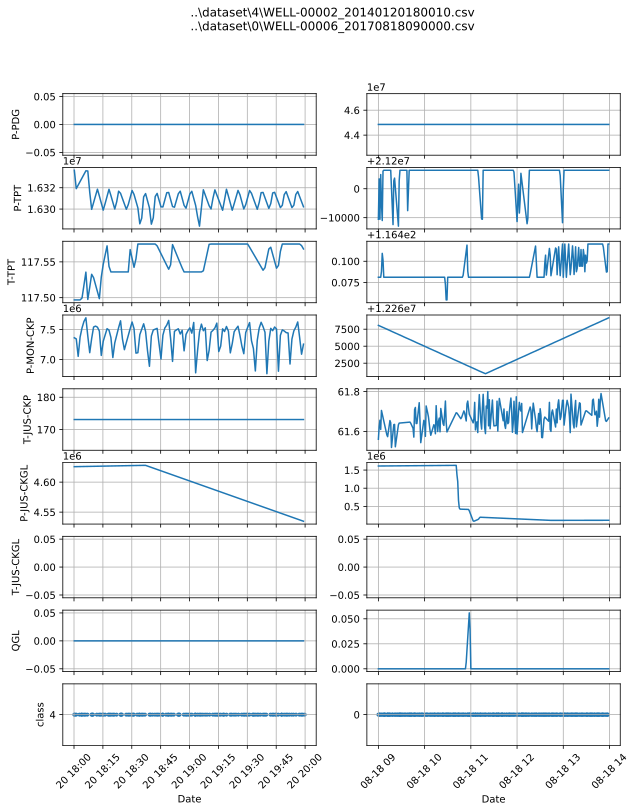

In [8]:
gen.plot([0,7])
plt.savefig('plot.jpg')

### Ajuste del Modelo  

Fit the subset to River models:
- A time window of 15min is used for calculating the rolling statistics:  
     mean, std, min, max  
  of every feature
- The standard scaler and the rolling statistics are reinitialized every new time series
- The fit starts after a warming period (equal to the rolling window size)

In [9]:
def fit_model(data_df, flist, target, window_size: int, model0, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)

            if not EvalB:
                model.learn_one(xd, y)

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)

    print('\n', report)
    print('\n', report0)
    if dfB:
        return ys, y_preds, accuracies, report, ifiles, model, pd.DataFrame(df_list)
    return ys, y_preds, accuracies, report, ifiles, model

In [10]:
%%time

#model =  tree.HoeffdingTreeClassifier(delta=1.E-4)
#model =  multiclass.OneVsOneClassifier(tree.HoeffdingTreeClassifier(delta=1.E-4))
#model =  multiclass.OneVsOneClassifier(linear_model.PAClassifier(C=1.0, mode=1))
#model = multiclass.OneVsOneClassifier(linear_model.ALMAClassifier())
model = imblearn.RandomOverSampler((tree.HoeffdingTreeClassifier(delta=1.E-4)),
        desired_dist={0: 0.5, 4: 0.5}, seed=200560)


flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
window_size = 15
epochs = 15

reports = epochs*[0]
reportsv = epochs*[0]
models = []
for epoch in range(epochs):
    print('\nepoch: {}\n'.format(epoch+1))
    ys, y_preds, accuracies, reports[epoch], ifiles, model, df = fit_model(train_df, flist, 'class', window_size,
                                                                  model, dfB=True, EvalB=False)
    models.append(model)
    yse, y_predse, accuraciese, reportsv[epoch], _, _, v_df = fit_model(val_df, flist, 'class', window_size, 
                                                                model, dfB=True, EvalB=True)    


epoch: 1

files learned  423 / 423
 BalancedAccuracy: 90.91%

            Precision   Recall   F1       Support  
                                                  
     0.0      97.34%   92.63%   94.93%     70644  
     4.0      73.93%   89.20%   80.85%     16552  
                                                  
   Macro      85.64%   90.91%   87.89%            
   Micro      91.98%   91.98%   91.98%            
Weighted      92.90%   91.98%   92.26%            

                 91.98% accuracy                  
files learned  47 / 47
 BalancedAccuracy: 84.77%

            Precision   Recall   F1       Support  
                                                  
     0.0      95.28%   89.22%   92.15%      8060  
     4.0      62.58%   80.32%   70.35%      1809  
                                                  
   Macro      78.93%   84.77%   81.25%            
   Micro      87.59%   87.59%   87.59%            
Weighted      89.29%   87.59%   88.15%            

                

files learned  423 / 423
 BalancedAccuracy: 98.33%

            Precision   Recall   F1       Support  
                                                  
     0.0      99.58%   98.44%   99.00%     70644  
     4.0      93.64%   98.22%   95.88%     16552  
                                                  
   Macro      96.61%   98.33%   97.44%            
   Micro      98.40%   98.40%   98.40%            
Weighted      98.45%   98.40%   98.41%            

                 98.40% accuracy                  
files learned  47 / 47
 BalancedAccuracy: 96.34%

            Precision   Recall   F1       Support  
                                                  
     0.0      99.38%   95.33%   97.32%      8060  
     4.0      82.41%   97.35%   89.25%      1809  
                                                  
   Macro      90.89%   96.34%   93.29%            
   Micro      95.70%   95.70%   95.70%            
Weighted      96.27%   95.70%   95.84%            

                 95.70% acc

In [11]:
print('epoch    Train       Val')
for i, (x, y) in enumerate(zip(reports, reportsv)):
    print('  {:2d}    {:6.2f}%    {:6.2f}%'.format(i, x.get()*100, y.get()*100))

epoch    Train       Val
   0     90.91%     84.77%
   1     93.72%     89.58%
   2     94.54%     82.07%
   3     95.98%     83.35%
   4     96.75%     92.33%
   5     97.37%     92.66%
   6     97.61%     90.97%
   7     97.77%     91.59%
   8     98.33%     96.34%
   9     98.59%     84.43%
  10     98.66%     96.19%
  11     98.94%     95.69%
  12     98.87%     95.78%
  13     98.92%     96.39%
  14     99.00%     96.32%


In [12]:
model_fitted = deepcopy(models[8])
with open('model_4.pkl', 'wb') as f:
  pickle.dump(model_fitted, f)

In [ ]:
if pathlib.Path('model_4.pkl').exists():
  with open('model_4.pkl', 'rb') as f:
    model_fitted = pickle.load(f)

In [13]:
model_fitted.classifier.height

38

In [14]:
yse, y_predse, accuraciese, _, _, _, v_df = fit_model(val_df, flist, 'class', window_size, 
                                                            model_fitted, dfB=True, EvalB=True)    

files learned  47 / 47
 BalancedAccuracy: 96.34%

            Precision   Recall   F1       Support  
                                                  
     0.0      99.38%   95.33%   97.32%      8060  
     4.0      82.41%   97.35%   89.25%      1809  
                                                  
   Macro      90.89%   96.34%   93.29%            
   Micro      95.70%   95.70%   95.70%            
Weighted      96.27%   95.70%   95.84%            

                 95.70% accuracy                  


In [15]:
from sklearn.metrics import classification_report
#np.unique(y_preds, return_counts=True)
print(classification_report(yse, y_predse))

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      8060
         4.0       0.82      0.97      0.89      1809

    accuracy                           0.96      9869
   macro avg       0.91      0.96      0.93      9869
weighted avg       0.96      0.96      0.96      9869



In [16]:
%%time

# Variable Importance

from sklearn.ensemble import RandomForestClassifier

f_list = []
for f in df.columns:
    n = sum(df[f].isnull())
    print(f, n)
    if n == 0:
        f_list.append(f)
f_list = f_list[:-1]

forest = RandomForestClassifier(random_state=200560)
forest.fit(df[f_list], df['class'])
print('mean accuracy Random Forest: ', forest.score(df[f_list], df['class']))
varImp = {'var': f_list, 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp).sort_values(['varImp'], ascending=False)
print(varImp)

varImp = {'var': [x[0] for x in [x.split('_') for x in f_list]], 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp)
varImp = varImp.groupby('var').sum().sort_values(['varImp'], ascending=False).reset_index()
varImp

P-PDG_rmean 0
P-PDG_rSEM 0
P-PDG_rMax 0
P-PDG_rMin 0
P-TPT_rmean 0
P-TPT_rSEM 0
P-TPT_rMax 0
P-TPT_rMin 0
T-TPT_rmean 0
T-TPT_rSEM 0
T-TPT_rMax 0
T-TPT_rMin 0
P-MON-CKP_rmean 8450
P-MON-CKP_rSEM 8450
P-MON-CKP_rMax 8450
P-MON-CKP_rMin 8450
T-JUS-CKP_rmean 10716
T-JUS-CKP_rSEM 10716
T-JUS-CKP_rMax 10716
T-JUS-CKP_rMin 10716
P-JUS-CKGL_rmean 28535
P-JUS-CKGL_rSEM 28535
P-JUS-CKGL_rMax 28535
P-JUS-CKGL_rMin 28535
QGL_rmean 24386
QGL_rSEM 24386
QGL_rMax 24386
QGL_rMin 24386
class 0
mean accuracy Random Forest:  0.9998050369282995
            var    varImp
7    P-TPT_rMin  0.126750
6    P-TPT_rMax  0.126318
10   T-TPT_rMax  0.107878
5    P-TPT_rSEM  0.102320
11   T-TPT_rMin  0.100353
9    T-TPT_rSEM  0.092596
4   P-TPT_rmean  0.086548
8   T-TPT_rmean  0.081007
2    P-PDG_rMax  0.062015
1    P-PDG_rSEM  0.047279
0   P-PDG_rmean  0.038404
3    P-PDG_rMin  0.028532
CPU times: total: 16.5 s
Wall time: 17.7 s


,var,varImp
0,P-TPT,0.441936
1,T-TPT,0.381834
2,P-PDG,0.176230


In [17]:
# Random Forest on validation set
print(classification_report(v_df['class'], forest.predict((v_df[f_list]))))

              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93      8060
         4.0       0.73      0.49      0.59      1809

    accuracy                           0.87      9869
   macro avg       0.81      0.73      0.76      9869
weighted avg       0.86      0.87      0.86      9869



In [18]:
def plot_acc(accuracies, accuraciesD, supt, subt):
    plt.figure(figsize=(10,4))

    plt.ylabel('Accuracies')
    plt.plot(accuracies, label='Predict/Fit')
    plt.plot(accuraciesD, label='Evaluated')
    plt.legend(loc="lower right")
    plt.title(supt + '\n' + subt)
    m, M = np.quantile(accuracies, [0.05, 0.95])
    m, M = round(m-0.05, 1), round(M+0.05, 1)    
    m1, M1 = np.quantile(accuraciesD, [0.05, 0.95])
    m1, M1 = round(m1-0.05, 1), round(M1+0.05, 1)    
    plt.ylim([min(m, m1), max(M, M1)])
    plt.grid()
    plt.show()
    return

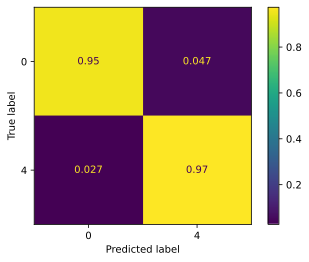

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay(confusion_matrix(yse, y_predse, labels=[0, 4], normalize='true'), 
                       display_labels=[0, 4]).plot()

## Drift test

In [21]:
class drift_reg:
    def __init__(self):
        self.d = {'i': [], 'n': [], 'ifile': [], 'label': [], 'y': [], 'path': [], 'warn': [], 
                  'change': [], 'origin': [], 'well': []}
        return
    def append(self, i, n, ifile, label, y, path, warn, change):
        self.d['i'].append(i)
        self.d['n'].append(n)
        self.d['ifile'].append(ifile)
        self.d['label'].append(label)
        self.d['y'].append(int(y))
        self.d['path'].append(path)
        self.d['warn'].append(warn)
        self.d['change'].append(change)
        self.d['well'].append(None)
        if (path.stem.startswith("SIMULATED")):
            self.d['origin'].append('S')
        elif path.stem.startswith("DRAWN"):
            self.d['origin'].append('D')
        else:
            self.d['origin'].append('R')
            if path.stem.startswith('WELL'):
                self.d['well'][-1] = int(path.stem[5:10])


        return
    def to_df(self):
        return pd.DataFrame(self.d)

In [22]:
def fit_modelD(data_df, flist, target, window_size: int, model0, dr, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
            print_warning = True
            drd = drift.EDDM(warm_start=30, alpha=0.8, beta=0.7)
            n = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)
            _ = drd.update(y != y_pred)
            warn = change = False
            if drd.warning_detected and print_warning:
                warn = True
                print(f"\nWarning detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = False
                dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change)
            if drd.drift_detected:
                change = True
                print(f"\nChange detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = True
                dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change)
            n += 1

            if not EvalB:
                model.learn_one(xd, y)

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)

    print('\n', report)
    print('\n', report0)
    if dfB:
        return ys, y_preds, accuracies, report, ifiles, model, pd.DataFrame(df_list)
    return ys, y_preds, accuracies, report, ifiles, model

In [23]:
dr = drift_reg()
yse, y_predse, accuraciese, report, ifiles, _, t_df = fit_modelD(test_df, flist, 'class', window_size, 
                                                            model_fitted, dr, dfB=True, EvalB=True)    

files learned  12 / 471
Change detected at index 2844 92, ifile 11, label 0 0.0 WELL-00001_20170424230156
files learned  13 / 471
Change detected at index 3127 75, ifile 12, label 4 4.0 WELL-00002_20140122200127
files learned  14 / 471
Change detected at index 3249 77, ifile 13, label 4 4.0 WELL-00001_20170318020000
files learned  16 / 471
Warning detected at index 3686 274, ifile 15, label 0 0.0 WELL-00001_20170525190000

Change detected at index 3696 284, ifile 15, label 0 0.0 WELL-00001_20170525190000
files learned  18 / 471
Warning detected at index 4283 276, ifile 17, label 0 0.0 WELL-00001_20170424180042
files learned  38 / 471
Warning detected at index 8293 42, ifile 37, label 0 0.0 WELL-00002_20131211230015

Change detected at index 8304 53, ifile 37, label 0 0.0 WELL-00002_20131211230015
files learned  41 / 471
Change detected at index 9037 67, ifile 40, label 4 4.0 WELL-00001_20170316140000
files learned  45 / 471
Change detected at index 10131 266, ifile 44, label 0 0.0 WELL

In [33]:
# train on complete files detected with drift

res = dr.to_df()

model_fittedD = deepcopy(model_fitted)

drift_files = res.ifile.unique()

t_df['ifile'] = ifiles

for i in t_df[t_df.ifile.isin(drift_files)].index:
    model_fittedD.learn_one(t_df.drop(['class', 'ifile'], axis=1).iloc[i].to_dict(), t_df.iloc[i]['class'])

In [ ]:
res = dr.to_df()

model_fittedD = deepcopy(model_fitted)
epochs = 1
last_ifile = -1
for i, rec in res.iterrows():
    print(i, rec['ifile'], rec['i'], rec['n'], rec['warn'], rec['change'])
    if rec['ifile'] != last_ifile:
        ini = -1
        fin = -1
        last_ifile = rec['ifile']
    if rec['warn']:
        ini = rec['i'] - min(30, rec['n'])
    elif rec['change']:
        if ini >= 0:
            fin = rec['i']
        else:
            ini = rec['i'] - min(30, rec['n'])
            fin = rec['i']
    if ini * fin >= 0:
        print('***', ini, fin)
        for epoch in range(epochs):
            for j in range(ini, fin+1):
                model_fittedD.learn_one(t_df.drop('class', axis=1).iloc[j].to_dict(), t_df.iloc[j]['class'])
            

In [34]:
drD = drift_reg()
yseD, y_predseD, accuracieseD, reportD, _, _ = fit_modelD(test_df, flist, 'class', window_size, 
                                                            model_fittedD, drD, dfB=False, EvalB=True)    

files learned  22 / 471
Change detected at index 4943 97, ifile 21, label 4 4.0 WELL-00002_20131209070000
files learned  48 / 471
Change detected at index 10685 102, ifile 47, label 4 4.0 WELL-00001_20170317040000
files learned  71 / 471
Warning detected at index 15724 114, ifile 70, label 0 0.0 WELL-00001_20170626100246

Change detected at index 15730 120, ifile 70, label 0 0.0 WELL-00001_20170626100246
files learned  73 / 471
Change detected at index 16105 79, ifile 72, label 4 4.0 WELL-00002_20140120080122
files learned  80 / 471
Change detected at index 17734 102, ifile 79, label 4 4.0 WELL-00002_20131209030000
files learned  95 / 471
Change detected at index 20575 71, ifile 94, label 0 0.0 WELL-00001_20170626200135
files learned  104 / 471
Warning detected at index 22789 68, ifile 103, label 0 0.0 WELL-00004_20140807160311
files learned  105 / 471
Warning detected at index 23091 252, ifile 104, label 0 0.0 WELL-00001_20170218110218
files learned  112 / 471
Warning detected at inde

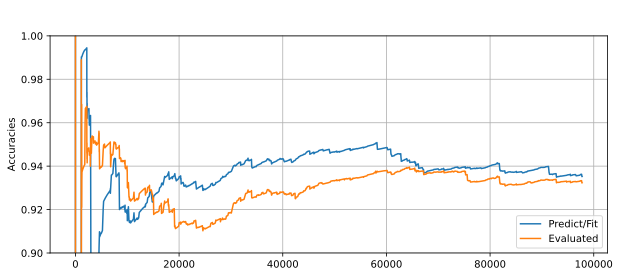

In [35]:
plot_acc(accuraciese, accuracieseD, '', '')

In [26]:
res = dr.to_df()
res.groupby(['origin', 'label', 'y', 'warn', 'change'])['path'].count()

origin  label  y  warn   change
R       0      0  False  True      23
                  True   False     15
        4      4  False  True      12
                  True   False      7
Name: path, dtype: int64

In [27]:
res.groupby(['origin', 'label', 'y', 'warn', 'change'])['path'].count() /\
            res.groupby(['origin', 'label', 'y'])['path'].count() * 100

origin  label  y  warn   change
R       0      0  False  True      60.526316
                  True   False     39.473684
        4      4  False  True      63.157895
                  True   False     36.842105
Name: path, dtype: float64

In [28]:
res.groupby(['origin', 'warn', 'change'])['path'].count() /\
            res.groupby(['origin'])['path'].count() * 100

origin  warn   change
R       False  True      61.403509
        True   False     38.596491
Name: path, dtype: float64

In [29]:
res.groupby(['label', 'warn', 'change'])['path'].count() /\
            res.groupby(['label'])['path'].count() * 100

label  warn   change
0      False  True      60.526316
       True   False     39.473684
4      False  True      63.157895
       True   False     36.842105
Name: path, dtype: float64

In [30]:
res.groupby(['y', 'warn', 'change'])['path'].count() /\
            res.groupby(['y'])['path'].count() * 100

y  warn   change
0  False  True      60.526316
   True   False     39.473684
4  False  True      63.157895
   True   False     36.842105
Name: path, dtype: float64

In [32]:
res.groupby(['well', 'warn', 'change'])['path'].count()

well  warn   change
1     False  True      14
      True   False     12
2     False  True       6
      True   False      4
4     False  True       3
      True   False      4
5     False  True       3
      True   False      1
6     False  True       7
7     False  True       2
      True   False      1
Name: path, dtype: int64